In [1]:
import keras
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
from keras.callbacks import ModelCheckpoint, EarlyStopping
# %reload_ext mermaid
# import IPython
# IPython.load_ipython_extensions(["nb-mermaid/nb-mermaid"]);

Using TensorFlow backend.


In [2]:
import tensorflow  as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D,Reshape, Dropout, Dense, GlobalAveragePooling2D, \
BatchNormalization, Input, Flatten, MaxPooling2D, UpSampling2D,Lambda
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import Adadelta, SGD, Adam
from keras.utils import to_categorical
import keras.backend as K

In [3]:
tf_config = tf.ConfigProto(allow_soft_placement=False)
tf_config.gpu_options.allow_growth = True
s = tf.Session(config=tf_config)
K.set_session(s)

In [4]:
csv_data = pd.read_csv('15features.csv')

In [5]:
display(csv_data.head()), csv_data.shape

,imagename,pen_pressure,letter_spacing,size,dimension,is_lowercase,is_continuous,slantness,tilt,entry_stroke_a,staff_of_a,formation_n,staff_of_d,exit_stroke_d,word_formation,constancy
0,0968c_num1.png,2,2,2,1,2,2,3,2,1,2,2,3,2,2,1
1,0809c_num2.png,2,2,2,2,2,2,3,1,1,2,2,3,1,2,2
2,0237b_num6.png,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2
3,0069b_num2.png,2,2,2,1,2,2,1,1,1,1,1,1,1,1,1
4,0966c_num4.png,2,2,2,2,2,2,2,1,1,2,2,2,2,2,2


(None, (13570, 16))

In [6]:
train_path = 'unseen-dataset/TrainingSet/'
train_images = os.listdir(train_path)
len(train_images)
val_path = 'unseen-dataset/ValidationSet/'
val_images = os.listdir(val_path)
len(val_images)

888

In [7]:
input_img = Input(shape=(64, 64, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='encoded')(x)
# encoded = GlobalAveragePooling2D()(x)

# encoder = Model(input_img, encoded)
# encoder.summary()
# print(encoded.shape)
# encoded = Flatten()(x)
# encoded = Dense(8*8*8)(encoded)
# # model = Model(input_img,encoded)
# # print(model.summary())
# # at this point the representation is (4, 4, 8) i.e. 128-dimensional
# r = Reshape(target_shape=(8,8,8))(encoded)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same',name='output')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
__________

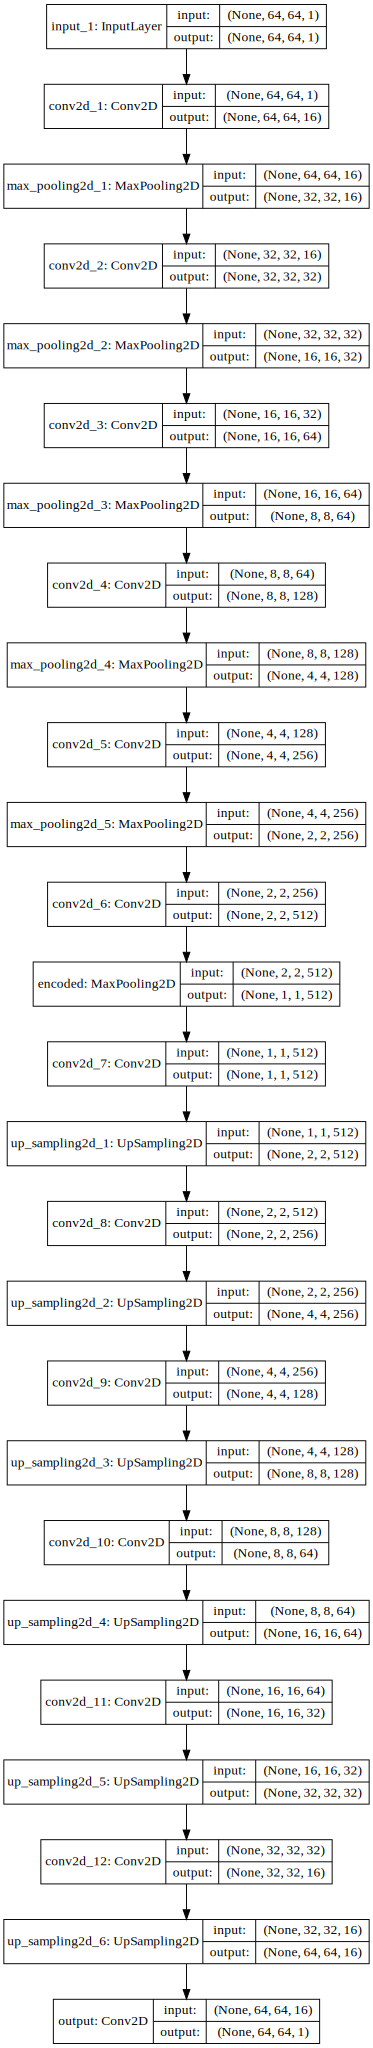

In [8]:

SVG(model_to_dot(autoencoder, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

In [9]:

def datagen(batch_size,image_path,list_of_writers, hshift = (-64,64) ,vis=False):
    counter = 0
    
    
    while True:
        counter = 0
        # for writer in unique_writers:
        #     print(identitycounter*100/stop_at, end='\r')
        w_ids,ids = [],[]
        writer_indexes = np.random.randint(0,len(list_of_writers),batch_size)
        x,y,writers = [],[],[]
        for writer_index in writer_indexes:
#             class_vectors = []
            writer = list_of_writers[writer_index]
#             print(writer)
#             writer_samples = list(images[images['image'].str.match(writer)]['image'])
#             print('writer:',writer,', writer_samples:',writer_samples)
#             if len(writer_samples) == 0:
#                 continue
#             writer_sample_index = np.random.randint(0,len(writer_samples))

#             #     unique_writers_count[writer] = len(writer_samples)
# #             print('writer_sample_index:',writer_sample_index)
#             csv_writer = writer_samples[writer_sample_index][:5]

    
            loaded_image = cv2.imread(os.path.join(image_path,writer),0)
            rand = np.random.randint(hshift[0],hshift[1])
            loaded_image_shifted=np.roll(axis=0,a=loaded_image,shift=rand)
#             loaded_image = np.expand_dims(loaded_image,-1)
#             loaded_image_shifted = np.expand_dims(loaded_image_shifted,-1)
#             print('csv_writer:', csv_writer, ', writer:', writer)
#             display(csv_data[csv_data['ImageId'].str.match(csv_writer)])
#             csv_discreete_features = csv_data[csv_data['ImageId'].str.match(csv_writer)].iloc[0].values[2:]
#             print(csv_writer, writer_samples[writer_sample_index])
#             print(csv_writer,csv_discreete_features)
#             for i in range(1,9):
#                 print(csv_discreete_features[i-1],end=',')
#             f_1_out.append(csv_discreete_features[0])
#             f_2_out.append(csv_discreete_features[1])
#             f_3_out.append(csv_discreete_features[2])
#             f_4_out.append(csv_discreete_features[3])
#             f_5_out.append(csv_discreete_features[4])
#             f_6_out.append(csv_discreete_features[5])
#             f_7_out.append(csv_discreete_features[6])
#             f_8_out.append(csv_discreete_features[7])
#                 class_vectors.append(to_categorical(csv_discreete_features[i-1],num_classes=feature_lengths['f'+str(i)]))
#             print("\n",len(class_vectors))
#             print('\n-----------')
            
#             print("++++++++++++++++++++++[",counter,"]+++++++++++++++++++++++")
        #     imgcounter = 0
        #     for sample in writer_samples:
        #         imagepath = os.path.join(image_path,sample)
        #         raw_img = cv2.imread(imagepath)
        #         imgcounter+=1
        #     imgcounter=0
        #     identitycounter += 1
            x.append(255.0-loaded_image_shifted.reshape((64,64,1)))
            y.append(255.0-loaded_image.reshape((64,64,1)))
            w_ids.append(writer[:4])
            writers.append(writer)
            ids.append(writer_index)
            
            counter+=1
#             print('counter:', counter, end='\r')
        if counter <= batch_size:
            if vis== True:
                yield np.array(x)/255.0,[np.array(w_ids),np.array(writers)]
            else:
                yield np.array(x)/255.0,np.array(y)/255.0
                    

In [10]:
# # unique_writers_count
# f_count = {}
train_list_of_writers = train_images
val_list_of_writers = val_images
batch_size = 64

tg = datagen(batch_size,train_path,train_list_of_writers, hshift = (-64,64))
vg = datagen(batch_size,val_path,val_list_of_writers, hshift = (-64,64))
# test_g = datagen(4,val_list_of_writers, hshift = (-12,12))

In [11]:
# images
for i in range(10):
    inputs,y = next(tg)
inputs.shape , y.shape#, o[0].shape #, o[1].shape,o[2].shape,o[3].shape,o[4].shape,o[5].shape,o[6].shape,o[7].shape

((64, 64, 64, 1), (64, 64, 64, 1))

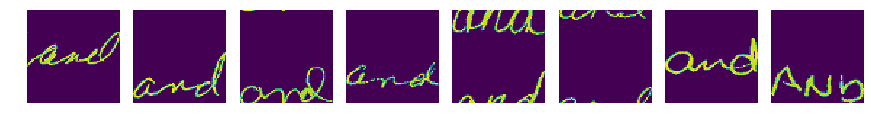

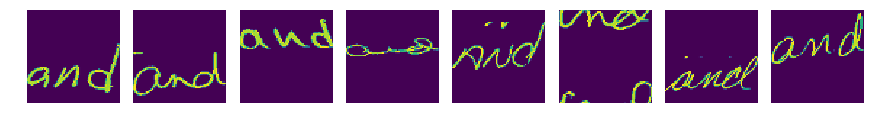

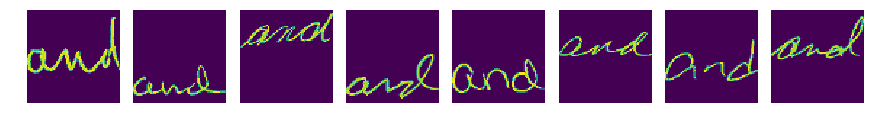

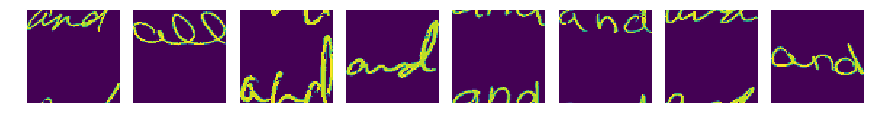

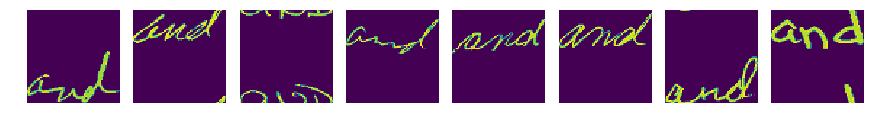

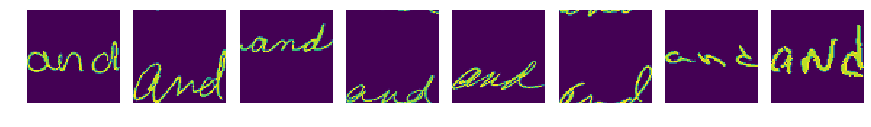

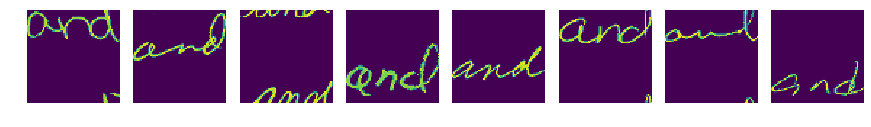

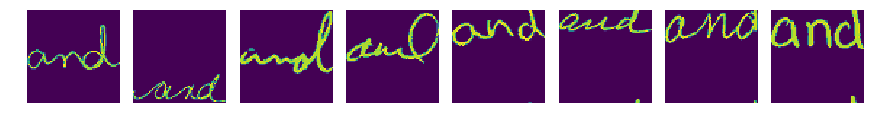

In [12]:
for r in range(8):
    f,ax = plt.subplots(1,8)
    f.subplots_adjust(hspace = .00, wspace=.15)
    f.set_size_inches(15,5)
    for c in range (8):
        ax[c].imshow(inputs[c+r*8].reshape((64,64)))
        ax[c].axis('off')

In [13]:
mc = ModelCheckpoint(filepath='weights/simple_ae_maxpool_Unseen_weights_v1.h5', monitor='val_loss',period=1,save_best_only=True,save_weights_only=True,mode='auto',verbose=3)
es = EarlyStopping(patience=10000, monitor='val_loss', min_delta=0.0005, mode='auto')
# autoencoder.load_weights('weights/simple_ae_maxpool_less_weights_v3.h5')

In [14]:
# EPOCHS = 50000

# hist = autoencoder.fit_generator(tg, callbacks=[mc,es]
#                                     , epochs=EPOCHS
#                                     , steps_per_epoch = 1
#                                     , validation_data = vg
#                                     , validation_steps = 1
#                                     , verbose = 3
                                    
#                                    )

0.08850246667861938


,val_loss,loss
7,0.104097,0.130967
24,0.103807,0.148132
29,0.104791,0.125098
38,0.102731,0.125499
44,0.102255,0.126362
48,0.100542,0.134570
54,0.104635,0.128908
70,0.098468,0.122930
71,0.098726,0.121256
93,0.104860,0.129207


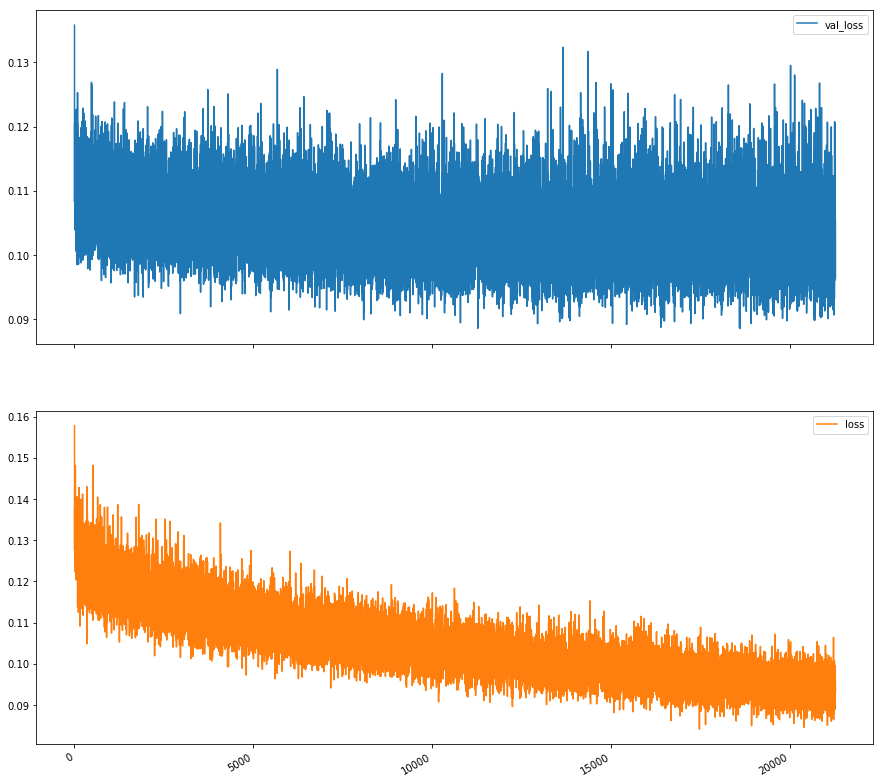

In [15]:
df_hist = pd.DataFrame(hist.history)
df_hist.plot(subplots=True, figsize=(15,15))
print(df_hist['val_loss'].min())
df_hist[df_hist['val_loss']<=0.1054]

In [29]:
# # print(df_hist.columns)
# print(df_hist['val_out_feature_1_acc'].max(), df_hist['val_out_feature_2_acc'].max(),
#        df_hist['val_out_feature_3_acc'].max(), df_hist['val_out_feature_4_acc'].max(),
#        df_hist['val_out_feature_5_acc'].max(), df_hist['val_out_feature_6_acc'].max(),
#        df_hist['val_out_feature_7_acc'].max(), df_hist['val_out_feature_8_acc'].max())
# # df_hist[df_hist['val_acc']>10.2]
df_hist

NameError: name 'df_hist' is not defined

In [18]:
test_g = datagen(len(val_list_of_writers)*5,val_path,val_list_of_writers, hshift = (-12,12), vis=True)
vx,vy = next(test_g)

(4440, 64, 64, 1) (4440,)


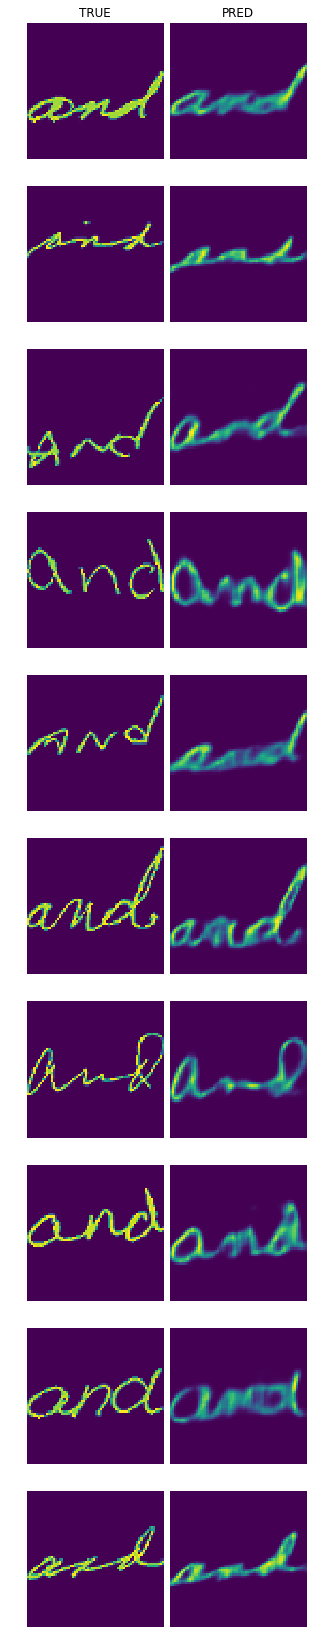

In [28]:

print(vx.shape,vy[0].shape)
py = autoencoder.predict(vx[:10])
f,ax = plt.subplots(len(vx[:10]),2)
f.subplots_adjust(hspace = .00, wspace=.05)
f.set_size_inches(5,len(vx[:10])*3)
ax[0,0].set_title('TRUE')
ax[0,1].set_title('PRED')
for i in range(len(vx[:10])):
#     print(vy[0][i], vy[1][i])
    ax[i,0].imshow(vx[i].reshape((64,64)))
    ax[i,0].axis('off')
    
    ax[i,1].imshow(py[i].reshape((64,64)))
    ax[i,1].axis('off')


In [20]:
autoencoder.load_weights('weights/simple_ae_maxpool_Unseen_weights_v1.h5')
encoder = Model(inputs=autoencoder.inputs,outputs=autoencoder.get_layer('encoded').output)


In [21]:
# df_val = pd.DataFrame(vy).T
# df_val.columns = ['identity','id','imagename']
# df_val = df_val.sort_values(by=['identity','imagename'])
# df_val = df_val.drop_duplicates()
# df_val = df_val.drop(columns=['id'])
# df_val

In [22]:
test_g = datagen(len(val_images)*5,val_path,val_images, hshift = (-10,10), vis=True)
testx,testy = next(test_g)

In [23]:
latent_pred_y = encoder.predict(testx).reshape((-1,512))

In [24]:
ids = testy[0].reshape(-1,1)
imagenames = testy[1].reshape(-1,1)
data=[]
for i in range(len(testx)):
    data.append([ids[i][0],imagenames[i][0],latent_pred_y[i]])
df_data = pd.DataFrame(data=data, columns=['identity','imagename','latent'])
# df_outs['ids'] = ids
# df_outs['preds'] = preds 
df_data=df_data.sort_values(by='identity').reset_index()
df_data.head(10)

,index,identity,imagename,latent
0,1125,1451,1451c_num5.png,"[0.0, 1.1129162, 0.007549895, 0.3144774, 0.0, ..."
1,3068,1451,1451c_num2.png,"[0.0, 0.0075935638, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
2,2604,1451,1451c_num6.png,"[0.0, 0.62083584, 0.0, 0.0, 0.4064646, 0.0, 0...."
3,3596,1451,1451a_num3.png,"[0.0, 0.2700171, 0.0, 0.041395627, 0.0, 0.7189..."
4,4238,1451,1451c_num6.png,"[0.0, 0.68080044, 0.0, 0.0, 0.55376166, 0.0, 0..."
5,491,1451,1451a_num2.png,"[0.0, 0.07799985, 0.0, 0.0, 0.124632165, 0.0, ..."
6,3018,1451,1451c_num6.png,"[0.0, 0.7106397, 0.0, 0.0, 0.04271929, 0.0, 0...."
7,1514,1451,1451b_num1.png,"[0.0, 0.3376596, 0.0, 0.1980556, 0.0, 0.0, 0.0..."
8,2303,1451,1451b_num3.png,"[0.0, 0.7169959, 0.57376534, 0.05812087, 0.0, ..."
9,4002,1451,1451c_num3.png,"[0.0, 0.43625352, 0.0, 0.0, 0.0, 0.058985204, ..."


In [25]:
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm_notebook

In [26]:
cos_dist_out = cosine_similarity(list(df_data['latent'].values))

In [27]:
recalls = []
precisions = []
threshs = []
for i in range(2,10):
    
    queried_count, idx_count, tp, tn, fp, fn = 0,0,0,0,0,0
    cos_thresh = i/10.0
    print('---------cos_thresh:',cos_thresh,'-----------')
    data_result = []
    fp_list = []
    fn_list = []
    r_counter = 0
    stop_at = 10
    prev_query = ''
    prev_given = ''
    given_count = 0
    threshs.append(cos_thresh)
    # total = cos_dist_out.shape[0]
    for row in tqdm_notebook(cos_dist_out):
        c_counter = 0
        given_idx = df_data.iloc[r_counter]['identity']
        given_img = df_data.iloc[r_counter]['imagename']
        for col in row:
            queried_idx = df_data.iloc[c_counter]['identity']
            queried_img = df_data.iloc[c_counter]['imagename']
            if int(given_idx) == int(queried_idx) and cos_dist_out[r_counter][c_counter]>cos_thresh:
                tp += 1
            if int(given_idx) != int(queried_idx) and cos_dist_out[r_counter][c_counter]<cos_thresh:
                tn += 1
            if int(given_idx) != int(queried_idx) and cos_dist_out[r_counter][c_counter]>cos_thresh:
                fp += 1
                fp_list.append(os.path.join(queried_idx,queried_img))
            if int(given_idx) == int(queried_idx) and cos_dist_out[r_counter][c_counter]<cos_thresh:
                fn += 1
                fn_list.append(os.path.join(queried_idx,queried_img))
            if int(given_idx) == int(queried_idx):
                idx_count += 1
    #             print('--i--',idx_count,'--i--')
    #             print(given_idx,queried_idx)
            if prev_query != queried_idx:
    #             print('--q--',queried_count,'--q--')
                queried_count += 1
            c_counter += 1
            prev_query = queried_idx
#             if queried_count == stop_at:
#                 break
        precision = tp/(fp+tp)
        recall = tp/(tp+fn)
        f1 = 2*(precision*recall)/(precision+recall)
        total = np.sum((tp,tn,fp,fn))
        accuracy = (tp+tn)/total
        data_result.append([given_idx,given_img, idx_count, tp, tn, fp, fn,precision,recall,f1,accuracy, total, fp_list, fn_list])
        if prev_given != given_idx:
    #         print('----',given_count,'-----')
            given_count+=1
        r_counter += 1
        prev_given = given_idx
        queried_count, idx_count, tp, tn, fp, fn = 0, 0, 0, 0, 0, 0
        fp_list = []
        fn_list = []
#         if given_count == stop_at:
#             break
    df_cos_dist_out = pd.DataFrame(data_result, columns=['identity','imagename','total_images_identity','TP','TN','FP','FN','precision','recall','f1','accuracy','total_images', 'FP_List','FN_List'])
    df_cos_dist_out=df_cos_dist_out.sort_values(by='identity',ascending=True).reset_index().drop(columns=['index'])
#     df_cos_dist_out.head()
    # print(df_cos_dist_out.keys())
    total = df_cos_dist_out.shape[0]
    total_images_identity = df_cos_dist_out['total_images_identity']
    tps = df_cos_dist_out['TP'].sum()
    fps = df_cos_dist_out['FP'].sum()
    tns = df_cos_dist_out['TN'].sum()
    fns = df_cos_dist_out['FN'].sum()
    print(tps,fps,tns,fns)
    precision = tps/(fps+tps)
    recall = tps/(tps+fns)
    recalls.append(recall)
    precisions.append(precision)
    f1 = 2*(precision*recall)/(precision+recall)
    print('precision:',precision,'\nrecall:',recall,'\nf1:',f1)
    acc = df_cos_dist_out['accuracy'].mean()
    print('Intra Writer Accuracy (Type 1):',np.mean(df_cos_dist_out['TP']/total_images_identity))
    print('Inter Writer Accuracy (Type 2)::',tns/total/total)
    print('acc:',acc)

---------cos_thresh: 0.2 -----------


16325 102526 4350 0
precision: 0.13735685858764335 
recall: 1.0 
f1: 0.24153695922353083
Intra Writer Accuracy (Type 1): 1.0
Inter Writer Accuracy (Type 2):: 0.035308154966274624
acc: 0.1678151963052248
---------cos_thresh: 0.3 -----------


16275 80334 26542 50
precision: 0.1684625655994783 
recall: 0.996937212863706 
f1: 0.28822143907060765
Intra Writer Accuracy (Type 1): 0.9967517050850384
Inter Writer Accuracy (Type 2):: 0.2154365630149106
acc: 0.3475377634921794
---------cos_thresh: 0.4 -----------


15263 49246 57630 1062
precision: 0.23660264459222743 
recall: 0.9349464012251149 
f1: 0.377638122572185
Intra Writer Accuracy (Type 1): 0.9109832657054879
Inter Writer Accuracy (Type 2):: 0.4677721771738865
acc: 0.5916591586107255
---------cos_thresh: 0.5 -----------


13771 21156 85720 2554
precision: 0.3942794972370945 
recall: 0.843552833078101 
f1: 0.5373839069694841
Intra Writer Accuracy (Type 1): 0.8237886565664342
Inter Writer Accuracy (Type 2):: 0.6957735732664507
acc: 0.8075502633907192
---------cos_thresh: 0.6 -----------


11761 7134 99742 4564
precision: 0.6224397988885949 
recall: 0.7204287901990811 
f1: 0.6678591709256104
Intra Writer Accuracy (Type 1): 0.7101481856111486
Inter Writer Accuracy (Type 2):: 0.8095875845163594
acc: 0.9050494720010389
---------cos_thresh: 0.7 -----------


8755 1550 105326 7570
precision: 0.8495875788452207 
recall: 0.5362940275650843 
f1: 0.6575291025159595
Intra Writer Accuracy (Type 1): 0.5297493219715442
Inter Writer Accuracy (Type 2):: 0.854911891948929
acc: 0.9259746268293276
---------cos_thresh: 0.8 -----------


4347 34 106842 11978
precision: 0.9922392147911435 
recall: 0.26627871362940275 
f1: 0.4198782961460446
Intra Writer Accuracy (Type 1): 0.2740102502139539
Inter Writer Accuracy (Type 2):: 0.8672169868751066
acc: 0.9025007913896803
---------cos_thresh: 0.9 -----------


2055 0 106876 14270
precision: 1.0 
recall: 0.12588055130168455 
f1: 0.22361262241566923
Intra Writer Accuracy (Type 1): 0.15128820999191372
Inter Writer Accuracy (Type 2):: 0.8674929586610498
acc: 0.8841730180761519


Text(0.5, 1.0, 'Chart to chose Threshold Value -  Deep Learning')

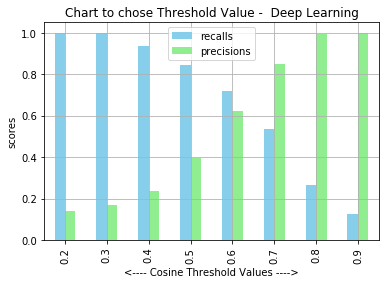

In [28]:
thresh_df = pd.DataFrame()
thresh_df['recalls']=recalls
thresh_df['precisions']=precisions
thresh_df['thresholds'] = threshs
ax=thresh_df[['recalls','precisions']].plot(kind='bar',color=['skyblue','lightgreen'],grid=True)
ax.set_xticklabels(list(thresh_df['thresholds']))
ax.set_xlabel("<---- Cosine Threshold Values ---->")
ax.set_ylabel("scores")
ax.set_title('Chart to chose Threshold Value -  Deep Learning')
# counter=-1
# for p in ax.patches:
#     print(p)
#     counter+=1
#     ax.annotate(str(p.get_height()), (counter*0.99,0))

In [113]:
df_cos_dist_out = pd.DataFrame(data_result, columns=['identity','imagename','total_images_identity','TP','TN','FP','FN','precision','recall','f1','accuracy','total_images', 'FP_List','FN_List'])
df_cos_dist_out=df_cos_dist_out.sort_values(by='identity',ascending=True).reset_index().drop(columns=['index'])
df_cos_dist_out

,identity,imagename,total_images_identity,TP,TN,FP,FN,precision,recall,f1,accuracy,total_images,FP_List,FN_List
0,1451,1451b_num1.png,59,4,298,0,55,1.0,0.067797,0.126984,0.845938,357,[],"[1451/1451a_num1.png, 1451/1451c_num6.png, 145..."
1,1451,1451c_num5.png,59,8,298,0,51,1.0,0.135593,0.238806,0.857143,357,[],"[1451/1451b_num1.png, 1451/1451a_num1.png, 145..."
2,1451,1451b_num1.png,59,5,298,0,54,1.0,0.084746,0.156250,0.848739,357,[],"[1451/1451c_num6.png, 1451/1451a_num2.png, 145..."
3,1451,1451c_num5.png,59,8,298,0,51,1.0,0.135593,0.238806,0.857143,357,[],"[1451/1451b_num1.png, 1451/1451a_num1.png, 145..."
4,1451,1451c_num3.png,59,7,298,0,52,1.0,0.118644,0.212121,0.854342,357,[],"[1451/1451b_num1.png, 1451/1451a_num1.png, 145..."
5,1451,1451c_num6.png,59,9,298,0,50,1.0,0.152542,0.264706,0.859944,357,[],"[1451/1451b_num1.png, 1451/1451a_num1.png, 145..."
6,1451,1451a_num2.png,59,13,298,0,46,1.0,0.220339,0.361111,0.871148,357,[],"[1451/1451b_num1.png, 1451/1451a_num1.png, 145..."
7,1451,1451c_num1.png,59,13,298,0,46,1.0,0.220339,0.361111,0.871148,357,[],"[1451/1451b_num1.png, 1451/1451a_num1.png, 145..."
8,1451,1451c_num5.png,59,8,298,0,51,1.0,0.135593,0.238806,0.857143,357,[],"[1451/1451b_num1.png, 1451/1451a_num1.png, 145..."
9,1451,1451c_num5.png,59,8,298,0,51,1.0,0.135593,0.238806,0.857143,357,[],"[1451/1451b_num1.png, 1451/1451a_num1.png, 145..."


In [114]:
# df_cos_dist_out=pd.read_csv('results-DL_AE_Maxpool_1x1x512_Unseen.csv')
# df_cos_dist_out

In [115]:
# print(df_cos_dist_out.keys())
total = df_cos_dist_out.shape[0]
total_images_identity = df_cos_dist_out['total_images_identity']
tps = df_cos_dist_out['TP'].sum()
fps = df_cos_dist_out['FP'].sum()
tns = df_cos_dist_out['TN'].sum()
fns = df_cos_dist_out['FN'].sum()
precision = tps/(fps+tps)
recall = tps/(tps+fns)
f1 = 2*(precision*recall)/(precision+recall)
print('precision:',precision,'\nrecall:',recall,'\nf1:',f1)
acc = df_cos_dist_out['accuracy'].mean()
print('Intra Writer Accuracy (Type 1):',np.mean(df_cos_dist_out['TP']/total_images_identity))
print('Inter Writer Accuracy (Type 2)::',tns/total/total)
print('acc:',acc)

precision: 0.999230917131321 
recall: 0.28338513550357164 
f1: 0.44154630416312657
Intra Writer Accuracy (Type 1): 0.289976862868653
Inter Writer Accuracy (Type 2):: 0.8560757636387888
acc: 0.8968528587905751


In [49]:
# df_cos_dist_out.to_csv('results-DL_AE_Maxpool_1x1x512_Shuffled.csv')
# left_image = '0103b_num1.png'
# right_image = '0012c_num3.png' #0 similarity
left_image = '0021c_num8.png'
right_image = '0021a_num1.png' #0 similarity

test_im_normal = (255.0-cv2.imread('../Handwriting/cleaned_AND_data_64x64/'+left_image,0))/255.0
test_im_shifted = (255.0-cv2.imread('../Handwriting/cleaned_AND_data_64x64/'+right_image,0))/255.0
py1 = encoder.predict(test_im_normal.reshape((1,64,64,1)))
py2 = encoder.predict(test_im_shifted.reshape((1,64,64,1)))
print(py1[py1==0].shape,py2[py2==0].shape)
py1 = py1.reshape((-1,512))
py2 = py2.reshape((-1,512))
print(py1.shape,py2.shape)
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, euclidean_distances
cosine_similarity(py1,py2), cosine_distances(py1,py2), euclidean_distances(py1,py2)

(308,) (278,)
(1, 512) (1, 512)


(array([[0.4444837]], dtype=float32),
 array([[0.5555163]], dtype=float32),
 array([[13.682199]], dtype=float32))

Text(0.5, 1.0, '0021a_num1.png')

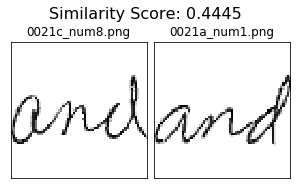

In [52]:
# print(test_im_normal.max())
f,ax = plt.subplots(1,2)
f.subplots_adjust(hspace = .00, wspace=.05)
f.set_size_inches(5,1*3)
f.suptitle('Similarity Score: '+str(np.round(cosine_similarity(py1,py2)[0][0],4)), fontsize=16)
ax[0].imshow(255.0-test_im_normal.reshape((64,64)),cmap="gray")
ax[0].axis('on')
ax[0].get_xaxis().set_ticks([])
ax[0].get_yaxis().set_ticks([])
ax[1].imshow(255.0-test_im_shifted.reshape((64,64)),cmap="gray")
ax[1].axis('on')
ax[1].get_xaxis().set_ticks([])
ax[1].get_yaxis().set_ticks([])
ax[0].set_title(left_image)
ax[1].set_title(right_image)

In [50]:
py1 = encoder.predict(test_im_normal.reshape((1,64,64,1)))
py2 = encoder.predict(test_im_shifted.reshape((1,64,64,1)))
py1[py1==0].shape,py2[py2==0].shape

((308,), (278,))

In [51]:
py1 = py1.reshape((-1,512))
py2 = py2.reshape((-1,512))
print(py1.shape,py2.shape)
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, euclidean_distances
cosine_similarity(py1,py2), cosine_distances(py1,py2), euclidean_distances(py1,py2)

(1, 512) (1, 512)


(array([[0.4444837]], dtype=float32),
 array([[0.5555163]], dtype=float32),
 array([[13.682199]], dtype=float32))

In [31]:
val_list_of_writers[:2]

['1469b_num3.png', '1453b_num4.png']